
## *Recognize Potato Plant Diseases*

### **Problem Selection:**

Many farmers who grow potatoes find themselves facing financial losses due to various diseases that can develop on potato plant leaves. Two common diseases are known as Early Blight and Late Blight.

Late Blight is often caused by fungi, while Early Blight is usually caused by bacteria.
If a farmer can detect these diseases at an early stage and prevent them, they can save significant time and avoid economic damage to the farmer.

DATASET :
[Potato Plant Diseases Dataset](https://www.kaggle.com/datasets/rizwan123456789/potato-disease-leaf-datasetpld)






In [ ]:
#Connect to GoogleDrive to save our progress
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import the relevant libraries.
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from tqdm import tqdm
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchvision import datasets, transforms


In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.device_count()

1

In [ ]:
!unzip /content/archive.zip -d /content/drive/MyDrive/final


Archive:  /content/archive.zip
  inflating: /content/drive/MyDrive/final/PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_1.jpg  
  inflating: /content/drive/MyDrive/final/PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_10.jpg  
  inflating: /content/drive/MyDrive/final/PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_100.jpg  
  inflating: /content/drive/MyDrive/final/PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_101.jpg  
  inflating: /content/drive/MyDrive/final/PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_102.jpg  
  inflating: /content/drive/MyDrive/final/PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_103.jpg  
  inflating: /content/drive/MyDrive/final/PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_104.jpg  
  inflating: /content/drive/MyDrive/final/PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_105.jpg  
  inflating: /content/drive/MyDrive/final/PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_106.jpg  
  inflating: /content/drive/MyDrive/

##Data Preparation

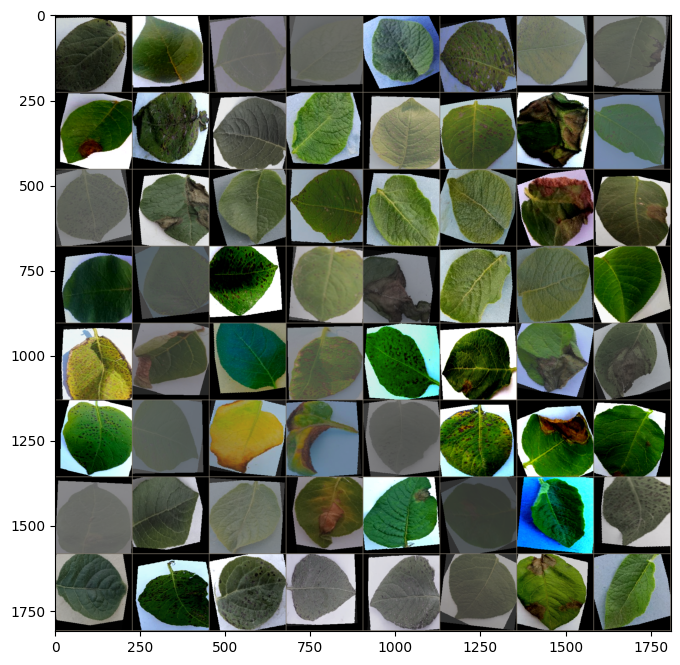

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

def imshow(img):
    img = img * std[:, None, None] + mean[:, None, None]
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.9, saturation=0.8, hue=0.03),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loading the data
data_dir = '/content/drive/MyDrive/final/PLD_3_Classes_256'
train_dataset = datasets.ImageFolder(root=data_dir + '/Training', transform=transform)
val_dataset = datasets.ImageFolder(root=data_dir + '/Validation', transform=transform)
test_dataset = datasets.ImageFolder(root=data_dir + '/Testing', transform=transform)

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

dataiter = iter(train_loader)
images, labels = next(dataiter)

# show some pictures from the current batch
imshow(torchvision.utils.make_grid(images))

##Model Building:  

In [ ]:

class PlantHealthCNN(nn.Module):
    def __init__(self):
        super(PlantHealthCNN, self).__init__()
        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # MaxPooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 28 * 28, 256)  # Image size after 3 pooling layers
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 3)  # 3 outputs

    def forward(self, x):
        # Convolution layers + ReLU + MaxPooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten
        x = x.view(-1, 128 * 28 * 28)

        # Fully Connected Layers + Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No ReLU in the output layer because there is softmax later
        return x


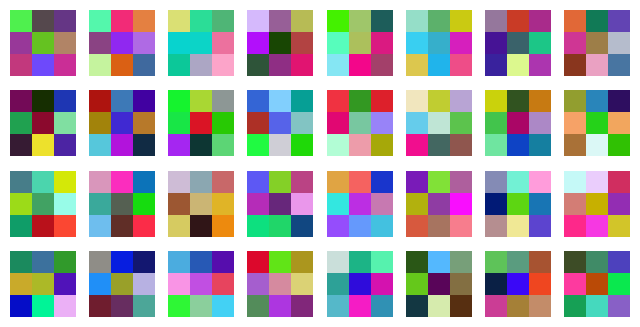

In [ ]:
def visualize_filters(layer):
    filters = layer.weight.data.clone()
    filters = filters - filters.min()
    filters = filters / filters.max()
    filter_num = filters.shape[0]
    n_columns = 8
    n_rows = filter_num // n_columns + (filter_num % n_columns > 0)
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(n_columns, n_rows))
    for i in range(filter_num):
        row = i // n_columns
        col = i % n_columns
        axs[row, col].imshow(filters[i].permute(1, 2, 0))
        axs[row, col].axis('off')
    plt.show()

model = PlantHealthCNN()
visualize_filters(model.conv1)

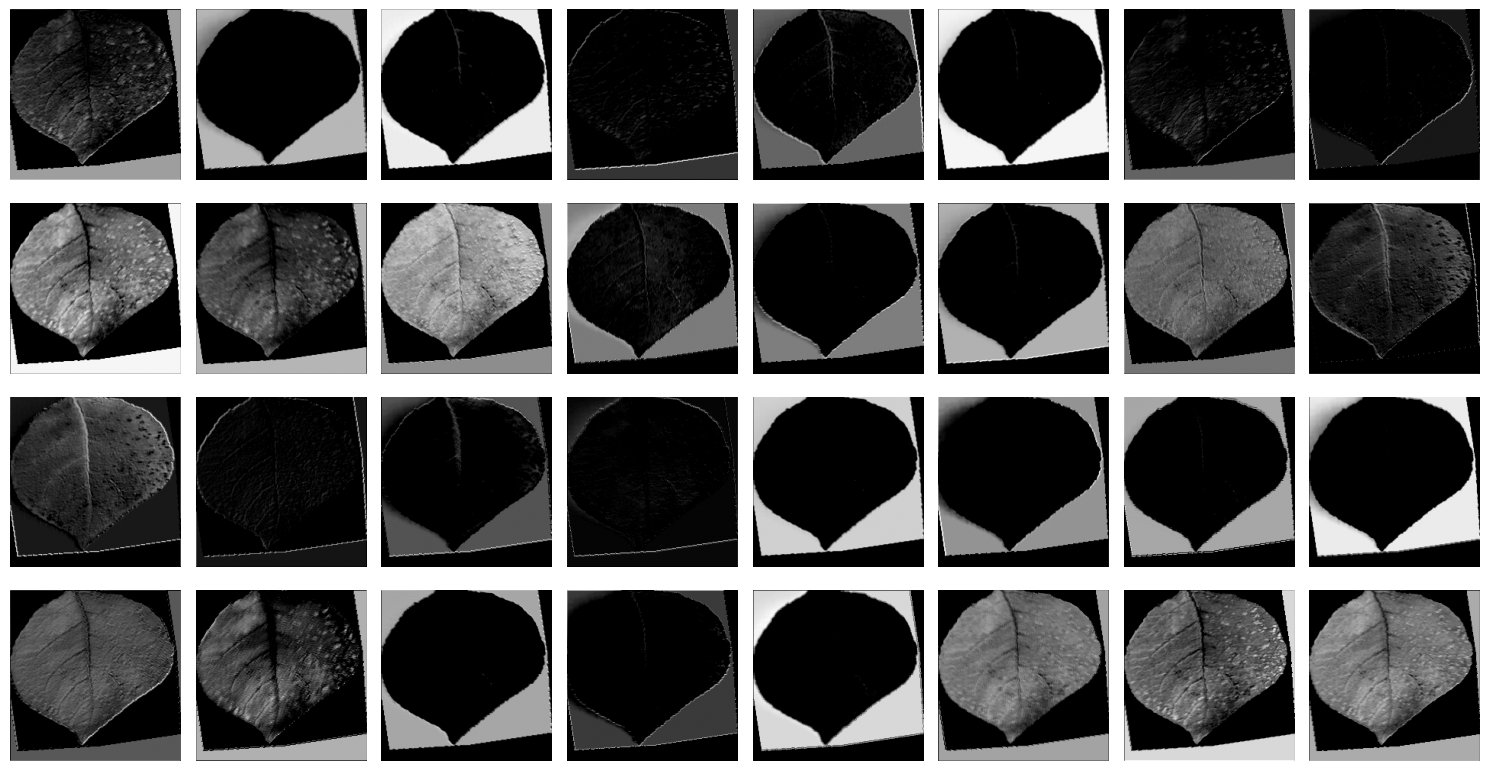

In [ ]:
def visualize_feature_maps(image, model):
    x = image.unsqueeze(0)  # Add batch dimension
    x = model.conv1(x)  # Pass through the first convolutional layer
    feature_maps = torch.relu(x).detach().squeeze(0)  # Apply ReLU and detach gradients

    # Normalize the feature maps for better visualization
    feature_maps = (feature_maps - feature_maps.min()) / (feature_maps.max() - feature_maps.min())

    num_maps = feature_maps.shape[0]
    n_columns = 8
    n_rows = num_maps // n_columns + (num_maps % n_columns > 0)

    fig, axs = plt.subplots(n_rows, n_columns, figsize=(15, 8))
    for i in range(num_maps):
        row = i // n_columns
        col = i % n_columns
        axs[row, col].imshow(feature_maps[i].numpy().transpose(0, 1),cmap='gray')
        axs[row, col].axis('off')

    # Hide unused subplots
    for i in range(num_maps, n_rows * n_columns):
        axs[i // n_columns, i % n_columns].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize feature maps for a single image
sample_image, _ = train_dataset[1]
visualize_feature_maps(sample_image, model)


##Training the model:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_losses = []
val_losses = []

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)  # reduce LR on plateau

# Training Loop
num_epochs = 100  # 100 EPOCHES
best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Training Phase
    model.train()
    train_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    scheduler.step(val_loss)  # Reduce LR on plateau

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model!")


Epoch 1/100


100%|██████████| 51/51 [20:24<00:00, 24.01s/it]


Train Loss: 1.1454, Validation Loss: 1.0555
Saved best model!
Epoch 2/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.9963, Validation Loss: 0.9524
Saved best model!
Epoch 3/100


100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Train Loss: 0.8896, Validation Loss: 0.7856
Saved best model!
Epoch 4/100


100%|██████████| 51/51 [00:45<00:00,  1.12it/s]


Train Loss: 0.8447, Validation Loss: 0.7982
Epoch 5/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.7790, Validation Loss: 0.7454
Saved best model!
Epoch 6/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.6860, Validation Loss: 0.5863
Saved best model!
Epoch 7/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.6685, Validation Loss: 0.6256
Epoch 8/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.6806, Validation Loss: 0.6125
Epoch 9/100


100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Train Loss: 0.5847, Validation Loss: 0.6111
Epoch 10/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.5757, Validation Loss: 0.5112
Saved best model!
Epoch 11/100


100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Train Loss: 0.5327, Validation Loss: 0.5690
Epoch 12/100


100%|██████████| 51/51 [00:44<00:00,  1.13it/s]


Train Loss: 0.4883, Validation Loss: 0.5350
Epoch 13/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.4847, Validation Loss: 0.4258
Saved best model!
Epoch 14/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.4562, Validation Loss: 0.4190
Saved best model!
Epoch 15/100


100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Train Loss: 0.4442, Validation Loss: 0.3919
Saved best model!
Epoch 16/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.4185, Validation Loss: 0.3883
Saved best model!
Epoch 17/100


100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Train Loss: 0.4085, Validation Loss: 0.3925
Epoch 18/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.3823, Validation Loss: 0.3189
Saved best model!
Epoch 19/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.3779, Validation Loss: 0.3194
Epoch 20/100


100%|██████████| 51/51 [00:43<00:00,  1.18it/s]


Train Loss: 0.3350, Validation Loss: 0.3776
Epoch 21/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.3476, Validation Loss: 0.3707
Epoch 22/100


100%|██████████| 51/51 [00:44<00:00,  1.14it/s]


Train Loss: 0.3269, Validation Loss: 0.3142
Saved best model!
Epoch 23/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.3198, Validation Loss: 0.3743
Epoch 24/100


100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Train Loss: 0.2992, Validation Loss: 0.3127
Saved best model!
Epoch 25/100


100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Train Loss: 0.3106, Validation Loss: 0.3321
Epoch 26/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.3104, Validation Loss: 0.2694
Saved best model!
Epoch 27/100


100%|██████████| 51/51 [00:44<00:00,  1.14it/s]


Train Loss: 0.3128, Validation Loss: 0.3288
Epoch 28/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.2767, Validation Loss: 0.3427
Epoch 29/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.2408, Validation Loss: 0.2867
Epoch 30/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.2830, Validation Loss: 0.3023
Epoch 31/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.2607, Validation Loss: 0.3929
Epoch 32/100


100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Train Loss: 0.2703, Validation Loss: 0.2399
Saved best model!
Epoch 33/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.2255, Validation Loss: 0.1950
Saved best model!
Epoch 34/100


100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Train Loss: 0.2351, Validation Loss: 0.2724
Epoch 35/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.2130, Validation Loss: 0.1848
Saved best model!
Epoch 36/100


100%|██████████| 51/51 [00:44<00:00,  1.14it/s]


Train Loss: 0.2065, Validation Loss: 0.2340
Epoch 37/100


100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Train Loss: 0.2113, Validation Loss: 0.1836
Saved best model!
Epoch 38/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.1964, Validation Loss: 0.1483
Saved best model!
Epoch 39/100


100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Train Loss: 0.1954, Validation Loss: 0.2028
Epoch 40/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.2093, Validation Loss: 0.2050
Epoch 41/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1957, Validation Loss: 0.1760
Epoch 42/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.1736, Validation Loss: 0.1740
Epoch 43/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1838, Validation Loss: 0.2379
Epoch 44/100


100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Train Loss: 0.1932, Validation Loss: 0.3707
Epoch 45/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1870, Validation Loss: 0.1552
Epoch 46/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1396, Validation Loss: 0.1343
Saved best model!
Epoch 47/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.1299, Validation Loss: 0.1177
Saved best model!
Epoch 48/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.1320, Validation Loss: 0.1348
Epoch 49/100


100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Train Loss: 0.1317, Validation Loss: 0.1114
Saved best model!
Epoch 50/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.1205, Validation Loss: 0.1049
Saved best model!
Epoch 51/100


100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Train Loss: 0.1074, Validation Loss: 0.1522
Epoch 52/100


100%|██████████| 51/51 [00:43<00:00,  1.18it/s]


Train Loss: 0.1150, Validation Loss: 0.1052
Epoch 53/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1128, Validation Loss: 0.1345
Epoch 54/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1249, Validation Loss: 0.1361
Epoch 55/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.1125, Validation Loss: 0.1171
Epoch 56/100


100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Train Loss: 0.1253, Validation Loss: 0.1212
Epoch 57/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1085, Validation Loss: 0.1275
Epoch 58/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.0995, Validation Loss: 0.1226
Epoch 59/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1137, Validation Loss: 0.1204
Epoch 60/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1120, Validation Loss: 0.1278
Epoch 61/100


100%|██████████| 51/51 [00:43<00:00,  1.18it/s]


Train Loss: 0.1183, Validation Loss: 0.1211
Epoch 62/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1077, Validation Loss: 0.1081
Epoch 63/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.1093, Validation Loss: 0.1267
Epoch 64/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1045, Validation Loss: 0.1055
Epoch 65/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.0968, Validation Loss: 0.1079
Epoch 66/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1121, Validation Loss: 0.1063
Epoch 67/100


100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Train Loss: 0.1031, Validation Loss: 0.0953
Saved best model!
Epoch 68/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.1111, Validation Loss: 0.0924
Saved best model!
Epoch 69/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.1110, Validation Loss: 0.1150
Epoch 70/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.1103, Validation Loss: 0.1018
Epoch 71/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1030, Validation Loss: 0.1175
Epoch 72/100


100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Train Loss: 0.1193, Validation Loss: 0.1140
Epoch 73/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1097, Validation Loss: 0.1434
Epoch 74/100


100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Train Loss: 0.1070, Validation Loss: 0.1172
Epoch 75/100


100%|██████████| 51/51 [00:43<00:00,  1.16it/s]


Train Loss: 0.1092, Validation Loss: 0.1684
Epoch 76/100


100%|██████████| 51/51 [00:43<00:00,  1.18it/s]


Train Loss: 0.1006, Validation Loss: 0.1329
Epoch 77/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1034, Validation Loss: 0.1320
Epoch 78/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1069, Validation Loss: 0.1629
Epoch 79/100


100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Train Loss: 0.1098, Validation Loss: 0.1322
Epoch 80/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1192, Validation Loss: 0.0986
Epoch 81/100


100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Train Loss: 0.1095, Validation Loss: 0.1381
Epoch 82/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1107, Validation Loss: 0.1484
Epoch 83/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1184, Validation Loss: 0.1378
Epoch 84/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1027, Validation Loss: 0.1081
Epoch 85/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1134, Validation Loss: 0.1249
Epoch 86/100


100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Train Loss: 0.1101, Validation Loss: 0.0781
Saved best model!
Epoch 87/100


100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Train Loss: 0.1051, Validation Loss: 0.1305
Epoch 88/100


100%|██████████| 51/51 [00:43<00:00,  1.18it/s]


Train Loss: 0.1107, Validation Loss: 0.1264
Epoch 89/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1048, Validation Loss: 0.1116
Epoch 90/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.0986, Validation Loss: 0.1511
Epoch 91/100


100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Train Loss: 0.1177, Validation Loss: 0.0869
Epoch 92/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1151, Validation Loss: 0.1284
Epoch 93/100


100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Train Loss: 0.1148, Validation Loss: 0.1268
Epoch 94/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1045, Validation Loss: 0.1201
Epoch 95/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1015, Validation Loss: 0.1519
Epoch 96/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1024, Validation Loss: 0.1030
Epoch 97/100


100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


Train Loss: 0.1137, Validation Loss: 0.1157
Epoch 98/100


100%|██████████| 51/51 [00:44<00:00,  1.16it/s]


Train Loss: 0.1075, Validation Loss: 0.1309
Epoch 99/100


100%|██████████| 51/51 [00:43<00:00,  1.18it/s]


Train Loss: 0.1048, Validation Loss: 0.1208
Epoch 100/100


100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


Train Loss: 0.1181, Validation Loss: 0.1089


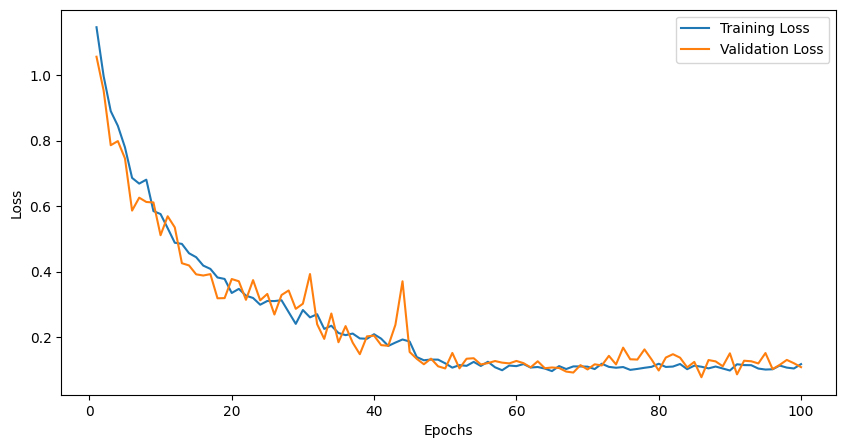

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


##Evaluation:  
Testing the Model

In [ ]:

# Define class names
class_names = ["early_blight", "healthy", "late_blight"]

# Test the model
correct = 0
total = 0
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Calculate Precision, Recall, and F1-Score
precision = precision_score(all_labels, all_preds, average='weighted')  #here we move on to weighted data
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Full classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))  #use the names the we define


Test Accuracy: 95.56%
Precision: 0.96
Recall: 0.96
F1-Score: 0.96

Classification Report:
              precision    recall  f1-score   support

early_blight       0.97      0.94      0.96       162
     healthy       0.92      0.98      0.95       102
 late_blight       0.96      0.95      0.96       141

    accuracy                           0.96       405
   macro avg       0.95      0.96      0.95       405
weighted avg       0.96      0.96      0.96       405



Confusion Matrix

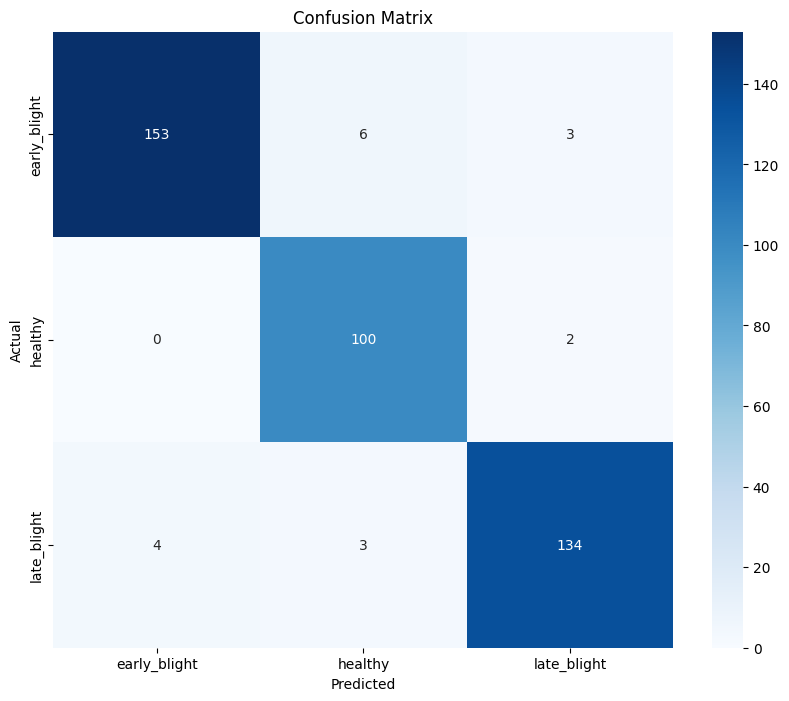

In [ ]:
import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_mat = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


##Visualization

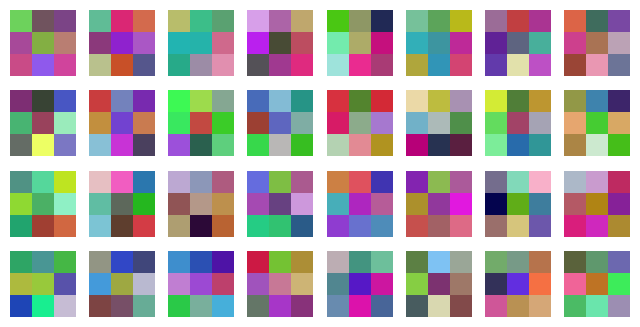

In [ ]:
model.to("cpu")
visualize_filters(model.conv1)

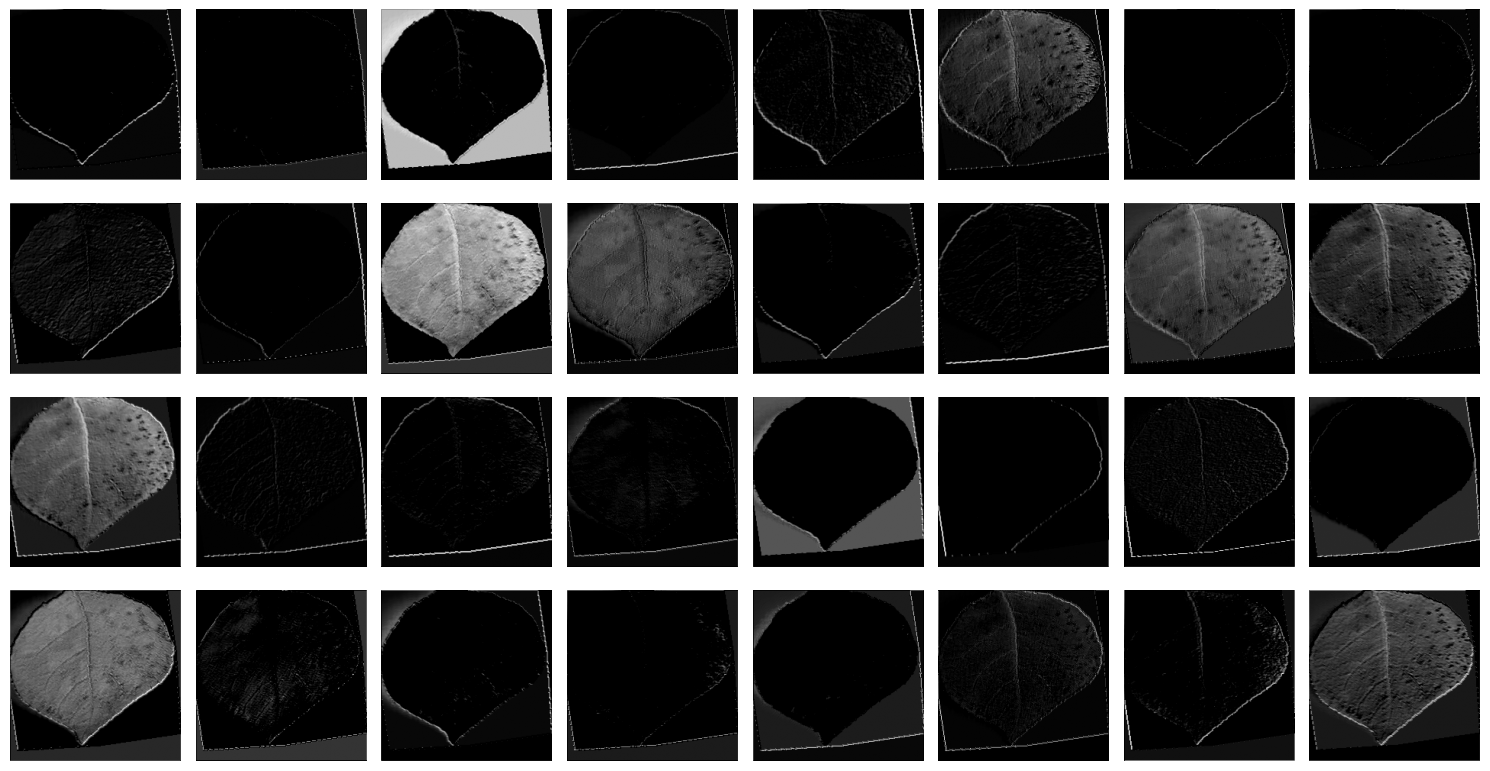

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def visualize_intermediate_layers(image, model, device):
    activations = []
    x = image.unsqueeze(0).to(device)  # Adding unsqueeze to match the model's input shape

# Showing operation on Convolution + ReLU + Max Pooling layers
    with torch.no_grad():  # No need to calculate gradients
        x = model.pool(F.relu(model.conv1(x)))
        activations.append(x)

        x = model.pool(F.relu(model.conv2(x)))
        activations.append(x)

        x = model.pool(F.relu(model.conv3(x)))
        activations.append(x)

    # Display the properties of each layer
    for idx, activation in enumerate(activations):
        feature_maps = activation.detach().squeeze(0) # Transform the first dimension (batch size)
        num_maps = feature_maps.shape[0]
        n_columns = 8
        n_rows = num_maps // n_columns + (num_maps % n_columns > 0)

        fig, axs = plt.subplots(n_rows, n_columns, figsize=(15, 8))
        fig.suptitle(f'Layer {idx+1} Feature Maps')

        # Presenting the features well
        for i in range(min(num_maps, n_columns * n_rows)):
            row = i // n_columns
            col = i % n_columns
            axs[row, col].imshow(feature_maps[i].cpu().numpy(), cmap='gray')
            axs[row, col].axis('off')

        plt.tight_layout()
        plt.show()
visualize_feature_maps(sample_image, model)


Training Curves:  
Plot training and validation loss curves over epochs.

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    model.to(device) # Move the model to the same device as the input data

    # The for loop was indented one level too far in
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

Epoch 1/10, Train Loss: 0.0971, Train Acc: 96.37%, Val Loss: 0.1032, Val Acc: 96.30%
Epoch 2/10, Train Loss: 0.1089, Train Acc: 96.83%, Val Loss: 0.1252, Val Acc: 96.05%
Epoch 3/10, Train Loss: 0.1033, Train Acc: 96.99%, Val Loss: 0.1393, Val Acc: 95.56%
Epoch 4/10, Train Loss: 0.1055, Train Acc: 96.52%, Val Loss: 0.1229, Val Acc: 95.80%
Epoch 5/10, Train Loss: 0.1160, Train Acc: 96.46%, Val Loss: 0.1361, Val Acc: 95.31%
Epoch 6/10, Train Loss: 0.1150, Train Acc: 96.19%, Val Loss: 0.1456, Val Acc: 95.31%
Epoch 7/10, Train Loss: 0.1134, Train Acc: 96.06%, Val Loss: 0.1271, Val Acc: 95.06%
Epoch 8/10, Train Loss: 0.1090, Train Acc: 96.52%, Val Loss: 0.1360, Val Acc: 96.30%
Epoch 9/10, Train Loss: 0.1113, Train Acc: 96.40%, Val Loss: 0.1094, Val Acc: 95.80%
Epoch 10/10, Train Loss: 0.1116, Train Acc: 96.12%, Val Loss: 0.1343, Val Acc: 95.56%


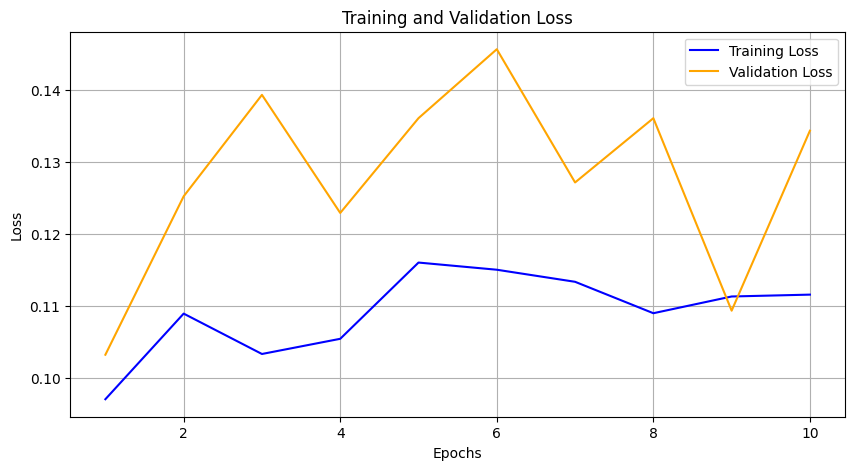

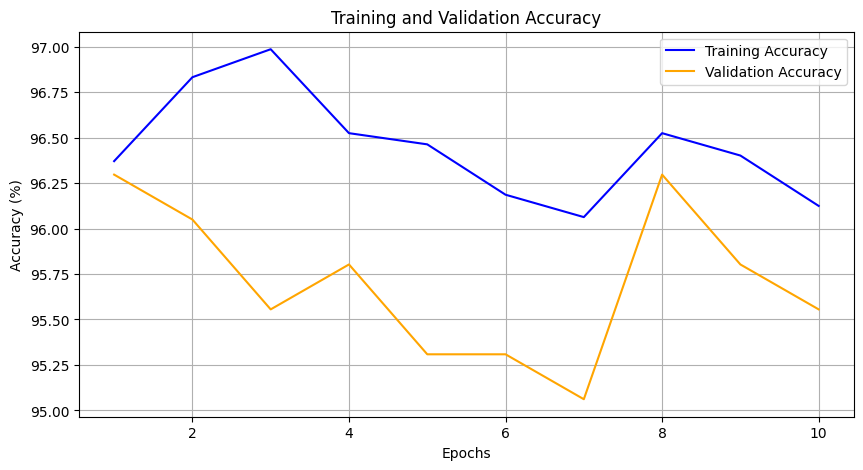

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


##Check our photos

Predicted Class: healthy


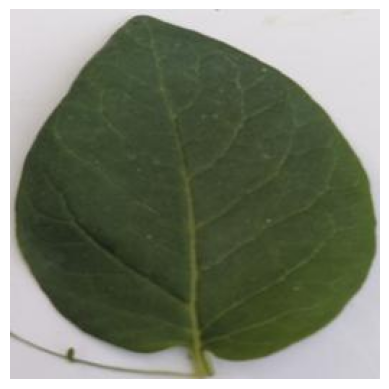

In [ ]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# If your model is already loaded
model.eval() # Make sure the model is in evaluation state

# Function to upload an image and categorize it
def classify_image(image_path, model, device):
    # Convert the image to a PIL object
    image = Image.open(image_path)

    # If the image is in RGBA, we will convert it to RGB
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    # Defining transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


    # Convert the image to Tensor
    image_tensor = transform(image).unsqueeze(0).to(device)  # Adding an additional dimension for batch prediction

    # Prediction
    with torch.no_grad():  # There is no need to save gradients because we are not training.
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)  # Outputs the predicted category

    # Show the prediction
    print(f"Predicted Class: {class_names[predicted.item()]}")

    # Show the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example of use
image_path = '/content/Healthy_91.jpg'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # If there is a GPU
model = model.to(device)  # Make sure the model is on the correct device.
classify_image(image_path, model, device)


In [ ]:
class_names = train_dataset.classes
print("Class names:", class_names)

Class names: ['Early_Blight', 'Healthy', 'Late_Blight']


Classifying image: Early_Blight_460.jpg
Predicted Class: Early_Blight


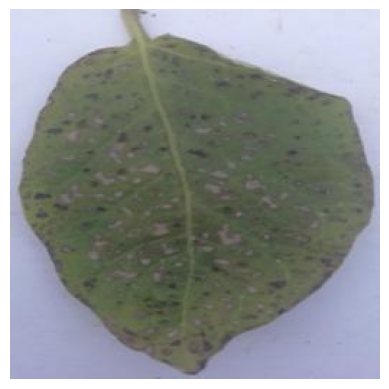

Classifying image: Early_Blight_1033.jpg
Predicted Class: Early_Blight


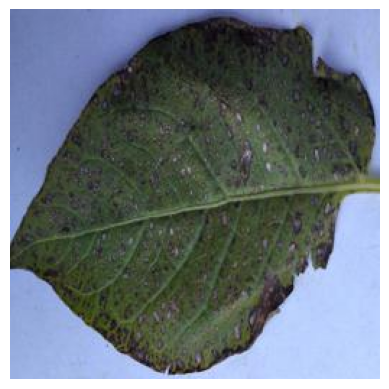

Classifying image: 2.earlyblight1.jpg
Predicted Class: Early_Blight


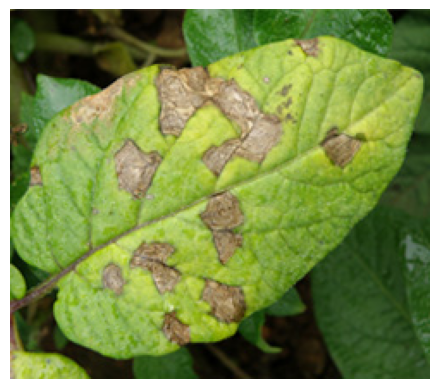

Classifying image: Early_Blight_1034.jpg
Predicted Class: Early_Blight


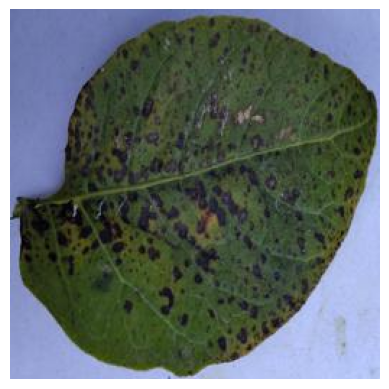

Classifying image: Early_Blight_1032.jpg
Predicted Class: Early_Blight


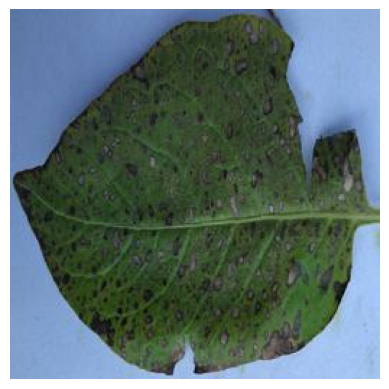

Classifying image: Early_Blight_1031.jpg
Predicted Class: Early_Blight


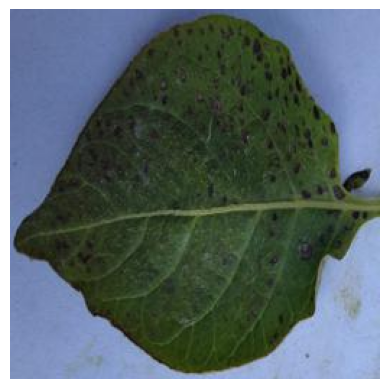

Classifying image: healthy_44.jpg
Predicted Class: Healthy


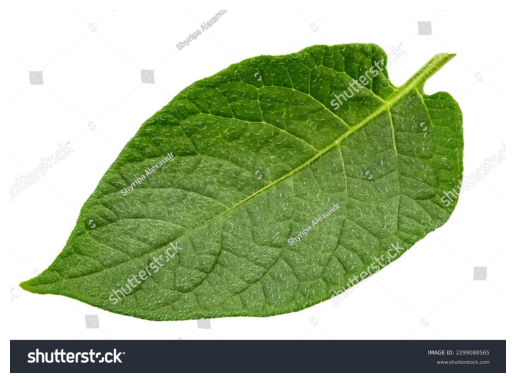

Classifying image: Healthy_91.jpg
Predicted Class: Healthy


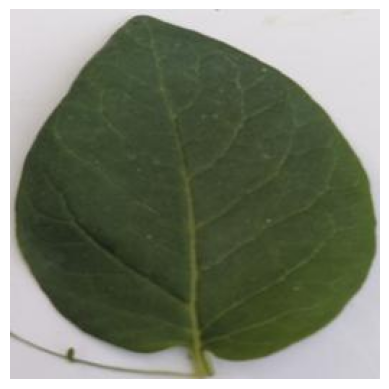

Classifying image: Healthy_329.jpg
Predicted Class: Healthy


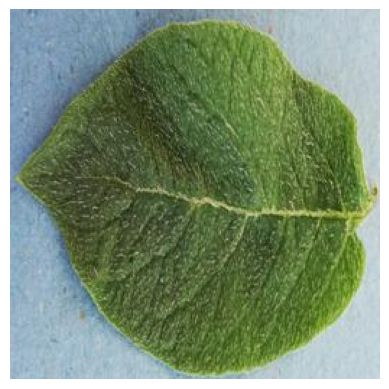

Classifying image: Healthy_343.jpg
Predicted Class: Healthy


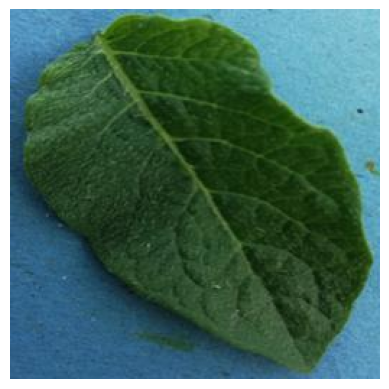

Classifying image: Late_Blight_10.jpg
Predicted Class: Late_Blight


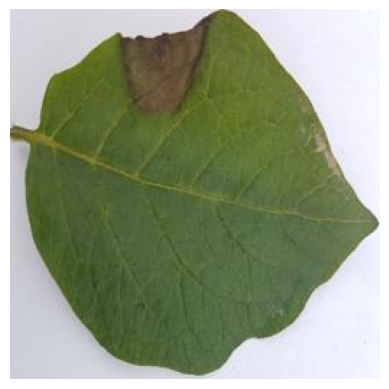

Classifying image: Late_Blight_28.jpg
Predicted Class: Late_Blight


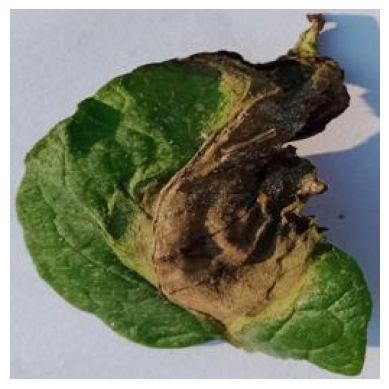

Classifying image: Late_Blight_575.jpg
Predicted Class: Late_Blight


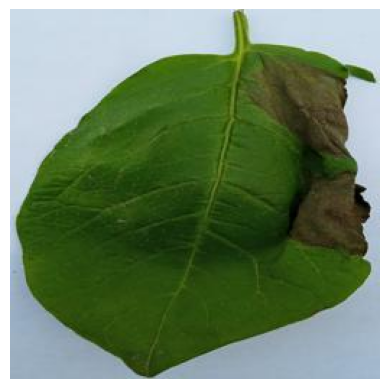

Classifying image: Late_Blight_797.jpg
Predicted Class: Late_Blight


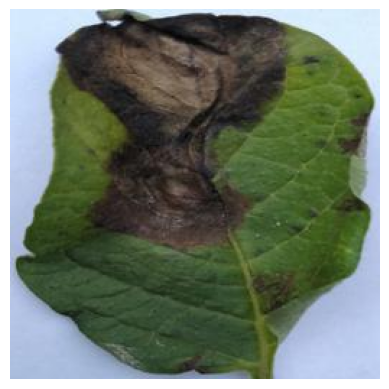

Classifying image: Late_Blight_798.jpg
Predicted Class: Late_Blight


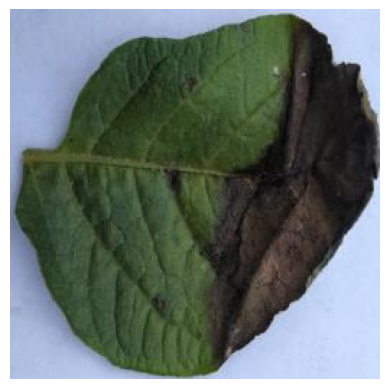

In [ ]:
import os

image_folder = '/content/drive/MyDrive/final/photos_of_leaf'

# Running a prediction on all images in the folder
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)

    # Make sure the file is an image
    if os.path.isfile(image_path) and image_name.endswith(('.jpg', '.jpeg', '.png')):
        print(f"Classifying image: {image_name}")
        classify_image(image_path, model, device)


### Discussion###
This sophisticated CNN model allows farmers to monitor Early Blight and Late Blight diseases of potato plants in a timely manner, allowing for early management of the diseases. This targeted approach leads to decreased pesticides usage and less crop damage because, with early detection, more effective treatments can be applied. This also improves yield and farm productivity while saving money. The model's speed and accuracy increases its efficiency, making farmers less dependant on manual inspections to visually check plants, which takes up a lot of time and is very unreliable. Technically, it gives farmers the tools they need to manage their crops effectively, leading to better economic returns per season.

With our model, farmers will be able to save tens of thousands of dollars a year by using less pesticides, if the disease is detected in the leaves at an early stage they will simply take them down and be able to replace them with other plants, instead of growing them in vain.

